In [1]:
%matplotlib inline
import os
import argparse
import sys
import subprocess
import random
import numpy as np
import matplotlib as mpl
# mpl.use('Agg')
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
import multiprocessing
import glob
import signal
import pandas as pd
import seaborn as sbn

In [2]:
path = "./statsN.log"

In [3]:
dtypeC={'refID':'object','tissue':'object','sample':'int','sf':'float','cov':'float','tpm':'float','chr':'object','start':'int','end':'int','tID':'object'}
data = pd.read_csv(path,sep="\t",skiprows=1,names=['tissue','chr','refID','tID','start','end','sample','sf','cov','tpm'],dtype=dtypeC)

# Aggregate a column for uniqueID
# ID column will be used for quantification of results and building the results DF
data["ID"] = data["tissue"]+":"+data["chr"]+":"+data['refID']+":"+data["tID"]+":"+data["start"].astype(str)+"-"+data["end"].astype(str)

# First reject all transcripts for which tpm==0.0 at sf==1.0
dataOff = pd.unique(data[(data["sf"] == 1.0) & (data["tpm"] == 0.0)]["ID"])
uniqueID1Maintain = pd.unique(data[~data["ID"].isin(dataOff)]["ID"])
dataN = data[~data["ID"].isin(uniqueID1Maintain)]
data = data[data["ID"].isin(uniqueID1Maintain)]

data["lost"] = data.apply(lambda row: row["tpm"] == 0.0,axis=1)

In [4]:
# 7 Computes the number of novel mistakes at each coverage point
setNo = set(dataN[(dataN["sf"]==1.0)&(dataN["tpm"]==0.0)]["ID"].unique()) # Lets try counting the number of novel mistake
setYes = set(dataN[(dataN["sf"]==1.0)&(dataN["tpm"]!=0.0)]["ID"].unique()) # Lets try counting the number of novel mistake
setFin = list(setNo.difference(setYes)) # Lets try counting the number of novel mistake
dataT = dataN[dataN['ID'].isin(setFin)]
dataSF = pd.DataFrame(dataT.groupby(['sf']).mean()).reset_index()
dataSF["NovelMistakes"] = dataSF.apply(lambda row: len(dataT[(dataT['ID'].isin(setFin))&(dataT["tpm"]!=0.0)&(dataT["sf"]==row["sf"])]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0


In [5]:
# 2 Here we shall also count the number of losses
dataSF["NumLostIndivSamples"] = dataSF.apply(lambda row: len(data[(data["sf"] == row["sf"])&(data["lost"])]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0


In [6]:
# 2 here we shall add information about total losses
dataLostAll = pd.DataFrame(data.groupby(["ID","sf"]).mean()).reset_index()
dataSF["NumLostAllSamples"] = dataSF.apply(lambda row: len(dataLostAll[(dataLostAll["sf"] == row["sf"])&(dataLostAll["lost"] == 1.0)]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0


In [7]:
# 3 Calculating the total number of transcripts at a particular coverage point
dataSF["NumTranscripts"] = pd.DataFrame(data.groupby(["sf"],as_index=False)["tpm"].count())["tpm"]
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730


In [8]:
# In the cells below we shall add information about quartiles,mean,cv and extreme outliers and outlier classification

# First we need to express tpm as percentage deviation from the baseTPM
# data["percentAway"] = data.apply(lambda row: row["tpm"]/data[(data["ID"] == row['ID'])&(data["sf"] == 1.0)]["tpm"],axis=1)
dictBase = pd.Series(data[data["sf"]==1.0].tpm.values,index=data[data["sf"]==1.0].ID).to_dict()
data["percentAway"] = data.apply(lambda row: (row["tpm"]/dictBase[row["ID"]])*100 if row["ID"] in dictBase else np.nan,axis=1)


In [9]:
dataSF["q25"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].quantile(0.25)).reset_index()["percentAway"]
dataSF["median"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].quantile(0.50)).reset_index()["percentAway"]
dataSF["q75"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].quantile(0.75)).reset_index()["percentAway"]
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,79.069121,100.956442,143.414926
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,89.256045,103.676539,122.894492
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,91.770261,102.203430,114.758617
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,95.280338,103.831785,113.417504
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,95.169894,101.824201,109.058635
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,96.678982,102.079618,107.660687
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,97.705701,102.052291,106.932563
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,98.193878,101.383482,105.149271
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,99.080142,101.318230,104.165093
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,100.000000,100.000000,100.000000


In [10]:
# get average tpm
dataSF["mean"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].mean()).reset_index()["percentAway"]
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,79.069121,100.956442,143.414926,176.458134
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,89.256045,103.676539,122.894492,150.934651
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,91.770261,102.203430,114.758617,145.689129
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,95.280338,103.831785,113.417504,137.843515
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,95.169894,101.824201,109.058635,134.326662
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,96.678982,102.079618,107.660687,126.445666
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,97.705701,102.052291,106.932563,110.144469
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,98.193878,101.383482,105.149271,107.295365
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,99.080142,101.318230,104.165093,105.863840
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,100.000000,100.000000,100.000000,100.000000


In [11]:
data

,tissue,chr,refID,tID,start,end,sample,sf,cov,tpm,ID,lost,percentAway
6,SRR2135415,chr1,TAS1R1,rna924,6570070,6579755,0,0.1,0.493871,2411.880859,SRR2135415 :chr1:TAS1R1:rna924:6570070-6579755,False,144.070626
18,SRR2135415,chr1,AADACL4,rna1390,12644547,12667086,0,0.1,1.417778,6923.896484,SRR2135415 :chr1:AADACL4:rna1390:12644547-126...,False,202.243800
75,SRR2135415,chr1,AHDC1,rna2835,27534249,27578324,0,0.1,0.442047,2158.791748,SRR2135415 :chr1:AHDC1:rna2835:27534249-27578324,False,101.275599
91,SRR2135415,chr1,HIVEP3,rna4222,41506548,41921323,0,0.1,0.201448,983.796509,SRR2135415 :chr1:HIVEP3:rna4222:41506548-4192...,False,80.716979
103,SRR2135415,chr1,SLC5A9,rna5044,48221114,48239315,0,0.1,0.000000,0.000000,SRR2135415 :chr1:SLC5A9:rna5044:48221114-4823...,True,0.000000
123,SRR2135415,chr1,C1orf87,rna5751,59990394,60073770,0,0.1,0.510848,2494.790039,SRR2135415 :chr1:C1orf87:rna5751:59990394-600...,False,202.425202
174,SRR2135415,chr1,IFI44,rna6506,78648554,78664078,0,0.1,0.000000,0.000000,SRR2135415 :chr1:IFI44:rna6506:78648554-78664078,True,0.000000
175,SRR2135415,chr1,IFI44,rna6507,78648554,78664078,0,0.1,0.000000,0.000000,SRR2135415 :chr1:IFI44:rna6507:78648554-78664078,True,0.000000
176,SRR2135415,chr1,IFI44,rna6508,78648554,78664078,0,0.1,0.000000,0.000000,SRR2135415 :chr1:IFI44:rna6508:78648554-78664078,True,0.000000
192,SRR2135415,chr1,CLCA4,rna6776,86547076,86580754,0,0.1,2.103330,10271.875000,SRR2135415 :chr1:CLCA4:rna6776:86547076-86580754,False,129.256847


In [12]:
# Here we shall calculate whiskers
def calcWhisk(row):
#     print(row["q25"])
    iqr = row["q75"] - row["q25"]
    lowWhisker = float(row["q25"])-1.5*float(iqr)
    highWhisker = float(row["q75"])+1.5*float(iqr)    
    wiskhi = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) <= highWhisker, np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))
    wisklo = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) >= lowWhisker, np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))
    
    extremesHigh = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) > np.max(wiskhi), np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))
    extremesLow = np.compress(np.array(list(data[data["sf"] == row["sf"]]["percentAway"])) < np.min(wisklo), np.array(list(data[data["sf"] == row["sf"]]["percentAway"])))  
    
    return [np.min(wisklo),np.max(wiskhi),extremesLow.tolist()+extremesHigh.tolist()]

dataSF[['whiskLow','whiskHigh','extremes']] = pd.DataFrame([x for x in dataSF.apply(lambda row: calcWhisk(row),axis=1)])
dataSF

/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean,whiskLow,whiskHigh,extremes
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,79.069121,100.956442,143.414926,176.458134,0.000000,239.872747,"[325.84642379, 715.749395052, 294.299100516, 6..."
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,89.256045,103.676539,122.894492,150.934651,39.083140,173.141945,"[0.0, 0.0, 0.0, 35.5219613674, 0.0, 29.4331607..."
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,91.770261,102.203430,114.758617,145.689129,57.502139,148.631348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5706067775, ..."
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,95.280338,103.831785,113.417504,137.843515,68.247087,140.497047,"[0.0, 0.0, 60.4105103361, 0.0, 43.2562415168, ..."
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,95.169894,101.824201,109.058635,134.326662,74.446665,129.434387,"[70.4511173888, 58.1516798885, 62.5235425473, ..."
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,96.678982,102.079618,107.660687,126.445666,81.302272,124.090144,"[73.3919534715, 0.0, 0.0, 69.8563228328, 0.0, ..."
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,97.705701,102.052291,106.932563,110.144469,83.924450,120.506833,"[0.0, 0.0, 81.2647355204, 83.3411324326, 49.42..."
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,98.193878,101.383482,105.149271,107.295365,87.794907,115.389266,"[76.109839038, 76.3103321183, 0.0, 83.96964281..."
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,99.080142,101.318230,104.165093,105.863840,91.469326,111.771205,"[89.1665308486, 89.2469816241, 73.5891173324, ..."
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,[]


In [13]:
# now it's time to count the number of outliers for each sf
dataSF["numExtremes"] = dataSF.apply(lambda row: len(row["extremes"]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean,whiskLow,whiskHigh,extremes,numExtremes
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,79.069121,100.956442,143.414926,176.458134,0.000000,239.872747,"[325.84642379, 715.749395052, 294.299100516, 6...",199
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,89.256045,103.676539,122.894492,150.934651,39.083140,173.141945,"[0.0, 0.0, 0.0, 35.5219613674, 0.0, 29.4331607...",531
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,91.770261,102.203430,114.758617,145.689129,57.502139,148.631348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5706067775, ...",501
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,95.280338,103.831785,113.417504,137.843515,68.247087,140.497047,"[0.0, 0.0, 60.4105103361, 0.0, 43.2562415168, ...",470
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,95.169894,101.824201,109.058635,134.326662,74.446665,129.434387,"[70.4511173888, 58.1516798885, 62.5235425473, ...",396
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,96.678982,102.079618,107.660687,126.445666,81.302272,124.090144,"[73.3919534715, 0.0, 0.0, 69.8563228328, 0.0, ...",418
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,97.705701,102.052291,106.932563,110.144469,83.924450,120.506833,"[0.0, 0.0, 81.2647355204, 83.3411324326, 49.42...",415
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,98.193878,101.383482,105.149271,107.295365,87.794907,115.389266,"[76.109839038, 76.3103321183, 0.0, 83.96964281...",423
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,99.080142,101.318230,104.165093,105.863840,91.469326,111.771205,"[89.1665308486, 89.2469816241, 73.5891173324, ...",302
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,[],0


In [14]:
# now we shall weigh the number of extremes by the mean distance from the median point at each sf
# the reason mean is chosen (and not the median) is because we want to assign weight based on how 
# badly the distribution is kewed and thus mean is a better option since it is biased heavily by the outliers

dataSF["weightedNumExtremes"] = dataSF.apply(lambda row: abs(np.array(row["extremes"])-row["median"]).mean()*row["numExtremes"],axis=1)
dataSF

/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice.
/home/sparrow/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,q25,median,q75,mean,whiskLow,whiskHigh,extremes,numExtremes,weightedNumExtremes
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,79.069121,100.956442,143.414926,176.458134,0.000000,239.872747,"[325.84642379, 715.749395052, 294.299100516, 6...",199,188903.379144
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,89.256045,103.676539,122.894492,150.934651,39.083140,173.141945,"[0.0, 0.0, 0.0, 35.5219613674, 0.0, 29.4331607...",531,161179.219831
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,91.770261,102.203430,114.758617,145.689129,57.502139,148.631348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5706067775, ...",501,147697.592274
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,95.280338,103.831785,113.417504,137.843515,68.247087,140.497047,"[0.0, 0.0, 60.4105103361, 0.0, 43.2562415168, ...",470,125044.929188
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,95.169894,101.824201,109.058635,134.326662,74.446665,129.434387,"[70.4511173888, 58.1516798885, 62.5235425473, ...",396,110309.939427
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,96.678982,102.079618,107.660687,126.445666,81.302272,124.090144,"[73.3919534715, 0.0, 0.0, 69.8563228328, 0.0, ...",418,86286.543457
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,97.705701,102.052291,106.932563,110.144469,83.924450,120.506833,"[0.0, 0.0, 81.2647355204, 83.3411324326, 49.42...",415,41734.869910
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,98.193878,101.383482,105.149271,107.295365,87.794907,115.389266,"[76.109839038, 76.3103321183, 0.0, 83.96964281...",423,30129.334826
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,99.080142,101.318230,104.165093,105.863840,91.469326,111.771205,"[89.1665308486, 89.2469816241, 73.5891173324, ...",302,22501.716757
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,[],0,NaN


In [15]:
# add standard deviation and coefficient of variation
dataSF["std"] = pd.DataFrame(data.groupby(["sf"])["percentAway"].std()).reset_index()["percentAway"]
dataSF["cv"] = dataSF.apply(lambda row: (row["std"]/row['mean'])*100,axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,...,median,q75,mean,whiskLow,whiskHigh,extremes,numExtremes,weightedNumExtremes,std,cv
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,...,100.956442,143.414926,176.458134,0.000000,239.872747,"[325.84642379, 715.749395052, 294.299100516, 6...",199,188903.379144,582.673009,330.204676
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,...,103.676539,122.894492,150.934651,39.083140,173.141945,"[0.0, 0.0, 0.0, 35.5219613674, 0.0, 29.4331607...",531,161179.219831,508.891203,337.159957
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,...,102.203430,114.758617,145.689129,57.502139,148.631348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5706067775, ...",501,147697.592274,497.938227,341.781319
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,...,103.831785,113.417504,137.843515,68.247087,140.497047,"[0.0, 0.0, 60.4105103361, 0.0, 43.2562415168, ...",470,125044.929188,480.803807,348.804081
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,...,101.824201,109.058635,134.326662,74.446665,129.434387,"[70.4511173888, 58.1516798885, 62.5235425473, ...",396,110309.939427,474.129559,352.967574
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,...,102.079618,107.660687,126.445666,81.302272,124.090144,"[73.3919534715, 0.0, 0.0, 69.8563228328, 0.0, ...",418,86286.543457,406.304537,321.327374
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,...,102.052291,106.932563,110.144469,83.924450,120.506833,"[0.0, 0.0, 81.2647355204, 83.3411324326, 49.42...",415,41734.869910,132.263597,120.081924
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,...,101.383482,105.149271,107.295365,87.794907,115.389266,"[76.109839038, 76.3103321183, 0.0, 83.96964281...",423,30129.334826,109.009743,101.597811
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,...,101.318230,104.165093,105.863840,91.469326,111.771205,"[89.1665308486, 89.2469816241, 73.5891173324, ...",302,22501.716757,107.766263,101.797047
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,...,100.000000,100.000000,100.000000,100.000000,100.000000,[],0,NaN,0.000000,0.000000


In [16]:
# STRATEGY 3: Time to include kendal tau ranking correlation results for each sf-base pair
# create an ID for distinguishing between samples
data["RankSampleID"] = data["ID"]+":"+data["sample"].astype(str)

def KendalTau(df,dfBASE):
    
    dfBASE = dfBASE.sort_values(by=["tpm","RankSampleID"],ascending=False)
    dfBASE = dfBASE.reset_index().drop("index",1)
    uniqueCOMBINATION = pd.unique(dfBASE["RankSampleID"])
    outDF = pd.DataFrame(uniqueCOMBINATION.reshape(uniqueCOMBINATION.shape[0],1),columns=["RankSampleID"])
    outDF[str(1.0)] = pd.DataFrame(np.array(range(1,uniqueCOMBINATION.shape[0]+1)).reshape(uniqueCOMBINATION.shape[0],1))

    df = df.sort_values(by=["tpm","RankSampleID"],ascending=False)
    df = df.reset_index().drop("index",1)
    uniqueCOMBINATION = pd.unique(df["RankSampleID"])
    df["rank"] = pd.DataFrame(np.array(range(1,uniqueCOMBINATION.shape[0]+1)).reshape(uniqueCOMBINATION.shape[0],1))

    outDF = pd.merge(outDF,df[["RankSampleID","rank"]],on='RankSampleID',how='outer')
    tau = outDF.corr(method="kendall")
    
    del dfBASE
    del df
    del uniqueCOMBINATION
    return tau["rank"]["1.0"]

dataSF["tau"] = dataSF.apply(lambda row: KendalTau(data[data["sf"] == row["sf"]][["RankSampleID","tpm"]],data[data["sf"] == 1.0][["RankSampleID","tpm"]]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,...,q75,mean,whiskLow,whiskHigh,extremes,numExtremes,weightedNumExtremes,std,cv,tau
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,...,143.414926,176.458134,0.000000,239.872747,"[325.84642379, 715.749395052, 294.299100516, 6...",199,188903.379144,582.673009,330.204676,0.622990
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,...,122.894492,150.934651,39.083140,173.141945,"[0.0, 0.0, 0.0, 35.5219613674, 0.0, 29.4331607...",531,161179.219831,508.891203,337.159957,0.741614
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,...,114.758617,145.689129,57.502139,148.631348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5706067775, ...",501,147697.592274,497.938227,341.781319,0.803799
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,...,113.417504,137.843515,68.247087,140.497047,"[0.0, 0.0, 60.4105103361, 0.0, 43.2562415168, ...",470,125044.929188,480.803807,348.804081,0.829651
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,...,109.058635,134.326662,74.446665,129.434387,"[70.4511173888, 58.1516798885, 62.5235425473, ...",396,110309.939427,474.129559,352.967574,0.879601
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,...,107.660687,126.445666,81.302272,124.090144,"[73.3919534715, 0.0, 0.0, 69.8563228328, 0.0, ...",418,86286.543457,406.304537,321.327374,0.891854
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,...,106.932563,110.144469,83.924450,120.506833,"[0.0, 0.0, 81.2647355204, 83.3411324326, 49.42...",415,41734.869910,132.263597,120.081924,0.914857
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,...,105.149271,107.295365,87.794907,115.389266,"[76.109839038, 76.3103321183, 0.0, 83.96964281...",423,30129.334826,109.009743,101.597811,0.937432
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,...,104.165093,105.863840,91.469326,111.771205,"[89.1665308486, 89.2469816241, 73.5891173324, ...",302,22501.716757,107.766263,101.797047,0.953674
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,...,100.000000,100.000000,100.000000,100.000000,[],0,NaN,0.000000,0.000000,1.000000


In [17]:
# STRATEGY 4: Weighted Kendal Tau
def KendalTauWeighted(df,dfBASE):
    def weight():
        dfCV = pd.DataFrame(df.groupby(["ID"])["tpm"].std()).reset_index()
        dfCV["mean"] = pd.DataFrame(df.groupby(["ID"])["tpm"].mean()).reset_index()["tpm"]
        dfCV["CV"] = dfCV.apply(lambda row: (row["tpm"]/row["mean"])*100.0 if not row["mean"] == 0.0 else np.nan,axis=1)
        dfCV["CVINV"] = dfCV.apply(lambda row: 1.0/row["CV"] if not row["CV"] == 0.0 else np.nan,axis=1)
        dfmean = dfCV["CVINV"].mean()
        del dfCV
        return dfmean
    
    dfBASE = dfBASE.sort_values(by=["tpm","ID"],ascending=False)
    dfBASE = dfBASE.reset_index().drop("index",1)
    uniqueCOMBINATION = pd.unique(dfBASE["ID"])
    outDF = pd.DataFrame(uniqueCOMBINATION.reshape(uniqueCOMBINATION.shape[0],1),columns=["ID"])
    outDF[str(1.0)] = pd.DataFrame(np.array(range(1,uniqueCOMBINATION.shape[0]+1)).reshape(uniqueCOMBINATION.shape[0],1))

    df = df.sort_values(by=["tpm","ID"],ascending=False)
    df = df.reset_index().drop("index",1)
    uniqueCOMBINATION = pd.unique(df["ID"])
    df["rank"] = pd.DataFrame(np.array(range(1,uniqueCOMBINATION.shape[0]+1)).reshape(uniqueCOMBINATION.shape[0],1))

    outDF = pd.merge(outDF,df[["ID","rank"]],on='ID',how='outer')
    tau = outDF.corr(method="kendall")
    
    del dfBASE
    del uniqueCOMBINATION
    
    return tau["rank"]["1.0"]*weight()

dataSF["tauW"] = dataSF.apply(lambda row: KendalTauWeighted(data[data["sf"] == row["sf"]][["ID","tpm"]],data[data["sf"] == 1.0][["ID","tpm"]]),axis=1)
dataSF

,sf,start,end,sample,cov,tpm,NovelMistakes,NumLostIndivSamples,NumLostAllSamples,NumTranscripts,...,mean,whiskLow,whiskHigh,extremes,numExtremes,weightedNumExtremes,std,cv,tau,tauW
0,0.1,7.507090e+07,7.516144e+07,4.504166,0.000090,0.434766,5,253,3,2499,...,176.458134,0.000000,239.872747,"[325.84642379, 715.749395052, 294.299100516, 6...",199,188903.379144,582.673009,330.204676,0.622990,0.020129
1,0.2,7.444671e+07,7.453592e+07,4.504346,0.000178,0.448889,5,180,1,2552,...,150.934651,39.083140,173.141945,"[0.0, 0.0, 0.0, 35.5219613674, 0.0, 29.4331607...",531,161179.219831,508.891203,337.159957,0.741614,0.061829
2,0.3,7.463111e+07,7.472021e+07,4.494094,0.000015,0.024936,1,139,1,2596,...,145.689129,57.502139,148.631348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.5706067775, ...",501,147697.592274,497.938227,341.781319,0.803799,0.098682
3,0.4,7.433896e+07,7.442762e+07,4.499877,0.000000,0.000000,0,127,0,2610,...,137.843515,68.247087,140.497047,"[0.0, 0.0, 60.4105103361, 0.0, 43.2562415168, ...",470,125044.929188,480.803807,348.804081,0.829651,0.074811
4,0.5,7.422442e+07,7.431277e+07,4.497200,0.000024,0.023599,1,82,0,2653,...,134.326662,74.446665,129.434387,"[70.4511173888, 58.1516798885, 62.5235425473, ...",396,110309.939427,474.129559,352.967574,0.879601,0.096213
5,0.6,7.432294e+07,7.441107e+07,4.507856,0.000000,0.000000,0,65,0,2665,...,126.445666,81.302272,124.090144,"[73.3919534715, 0.0, 0.0, 69.8563228328, 0.0, ...",418,86286.543457,406.304537,321.327374,0.891854,0.145343
6,0.7,7.423075e+07,7.431869e+07,4.505135,0.000000,0.000000,0,58,1,2691,...,110.144469,83.924450,120.506833,"[0.0, 0.0, 81.2647355204, 83.3411324326, 49.42...",415,41734.869910,132.263597,120.081924,0.914857,0.186360
7,0.8,7.437451e+07,7.446208e+07,4.496696,0.000000,0.000000,0,32,0,2697,...,107.295365,87.794907,115.389266,"[76.109839038, 76.3103321183, 0.0, 83.96964281...",423,30129.334826,109.009743,101.597811,0.937432,0.251407
8,0.9,7.430261e+07,7.439019e+07,4.499568,0.000000,0.000000,0,17,1,2721,...,105.863840,91.469326,111.771205,"[89.1665308486, 89.2469816241, 73.5891173324, ...",302,22501.716757,107.766263,101.797047,0.953674,0.305843
9,1.0,7.432721e+07,7.441466e+07,4.500000,0.000000,0.000000,0,0,0,2730,...,100.000000,100.000000,100.000000,[],0,NaN,0.000000,0.000000,1.000000,NaN


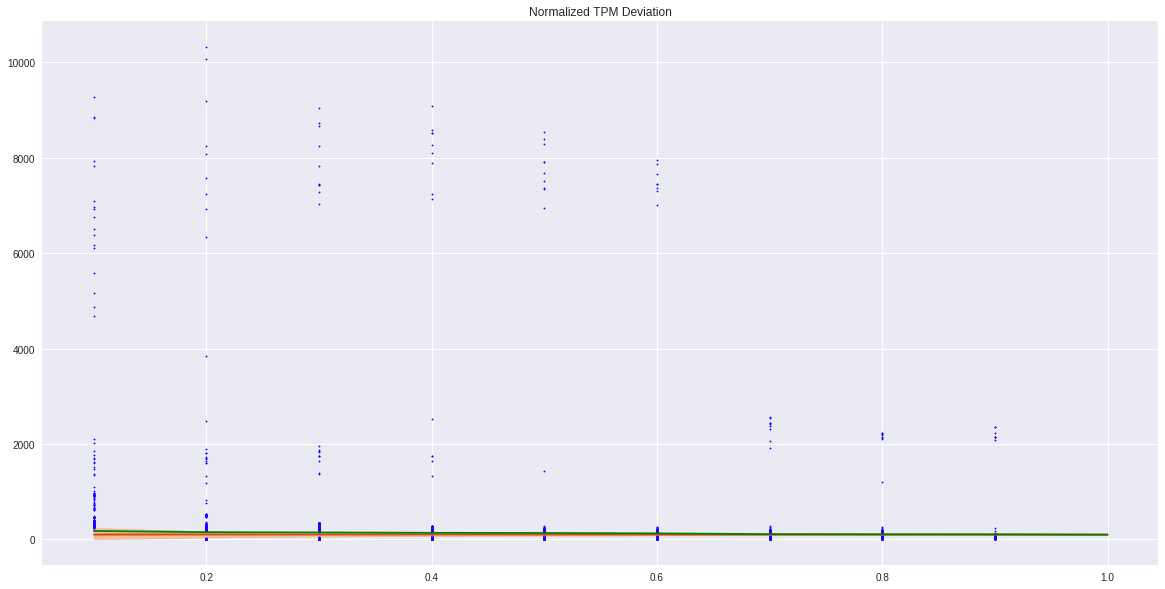

In [18]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Normalized TPM Deviation')
plt.plot(dataSF["sf"], dataSF["median"],'k',color='#CC4F1B')
for xe, ye in zip(dataSF["sf"], dataSF["extremes"]):
    plt.scatter([xe]*len(ye), ye, color='#1e00ff',s=2,vmin=0.1)
    
plt.fill_between(dataSF["sf"], dataSF["q25"], dataSF["q75"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.fill_between(dataSF["sf"], dataSF["whiskLow"], dataSF["whiskHigh"],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.plot(dataSF["sf"], dataSF["mean"],'k',color='green')

plt.show()

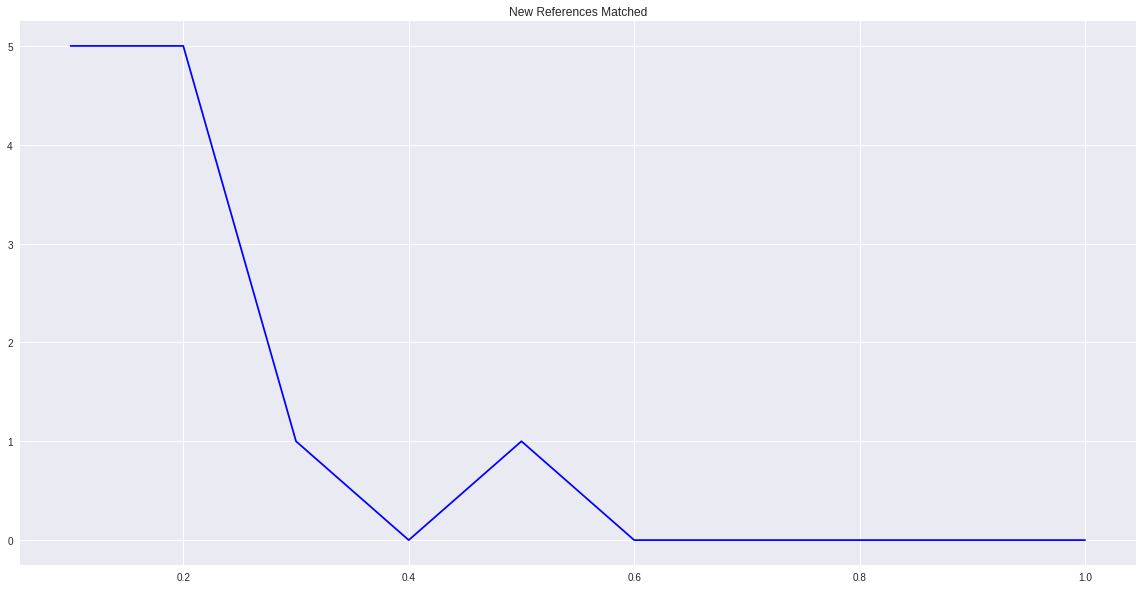

In [24]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('New References Matched')
plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
# plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
# plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
# plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

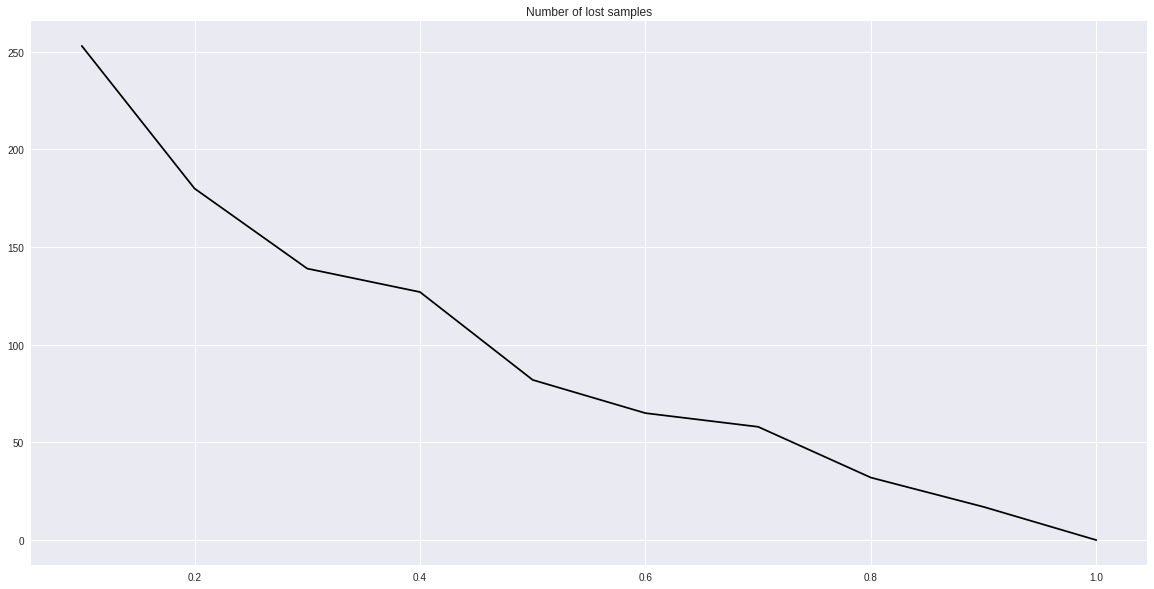

In [25]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Number of lost samples')
# plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
# plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
# plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

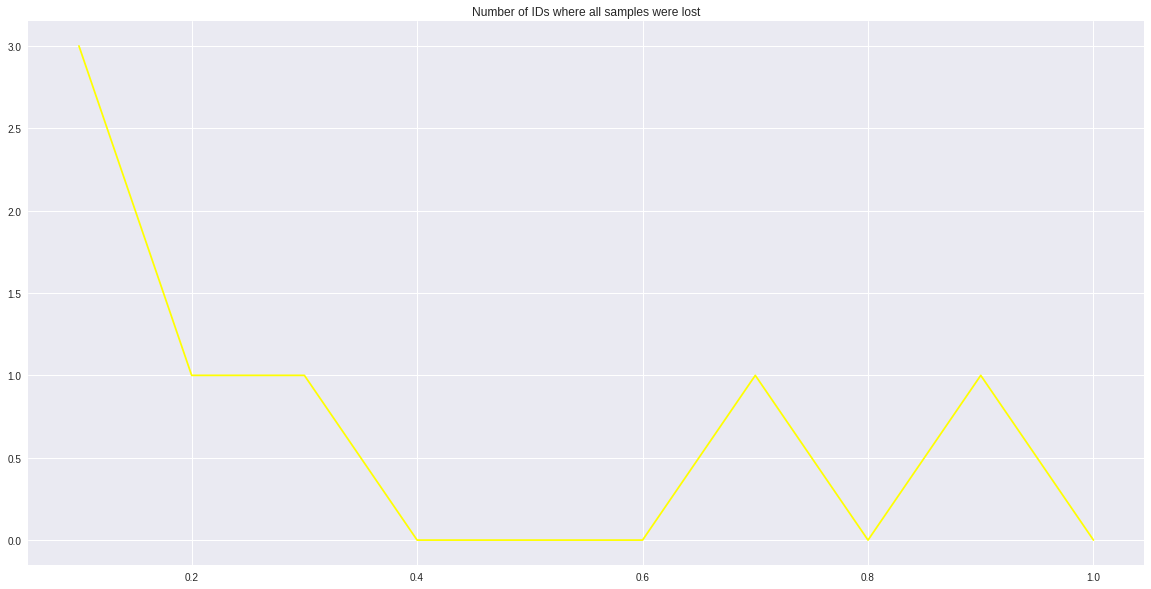

In [26]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Number of IDs where all samples were lost')
# plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
# plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
# plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

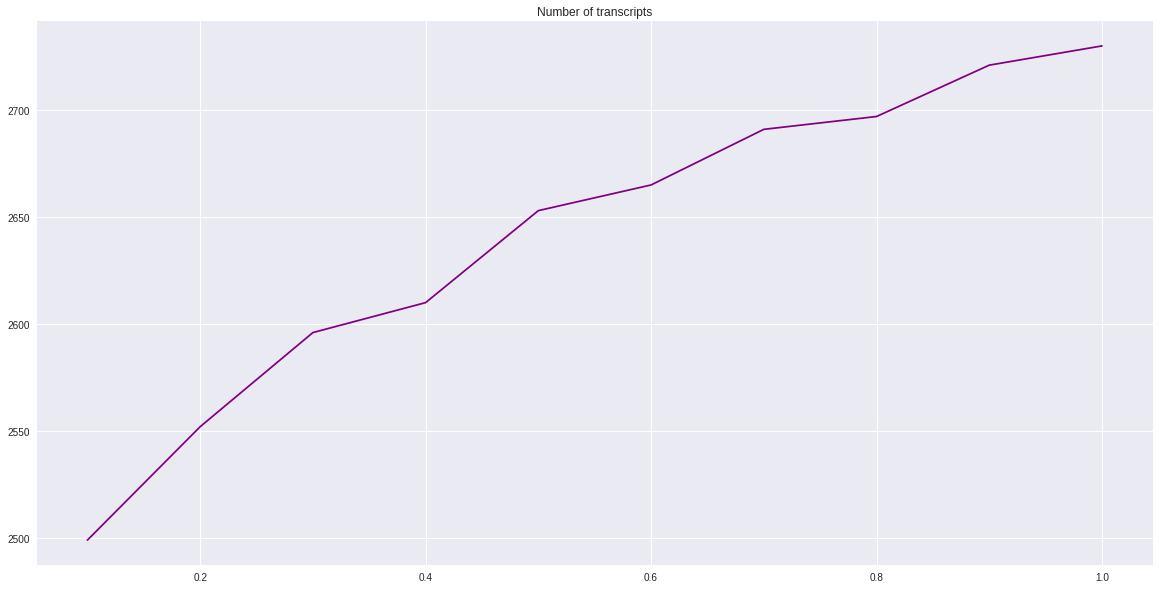

In [27]:
plt.close('all')
plt.figure(figsize=(20,10))
# plt.yscale('log',basey=2)
plt.title('Number of transcripts')
# plt.plot(dataSF["sf"], dataSF["NovelMistakes"],'k',color='blue')
# plt.plot(dataSF["sf"], dataSF["NumLostIndivSamples"],'k',color='black')
# plt.plot(dataSF["sf"], dataSF["NumLostAllSamples"],'k',color='yellow')
plt.plot(dataSF["sf"], dataSF["NumTranscripts"],'k',color='purple')

plt.show()

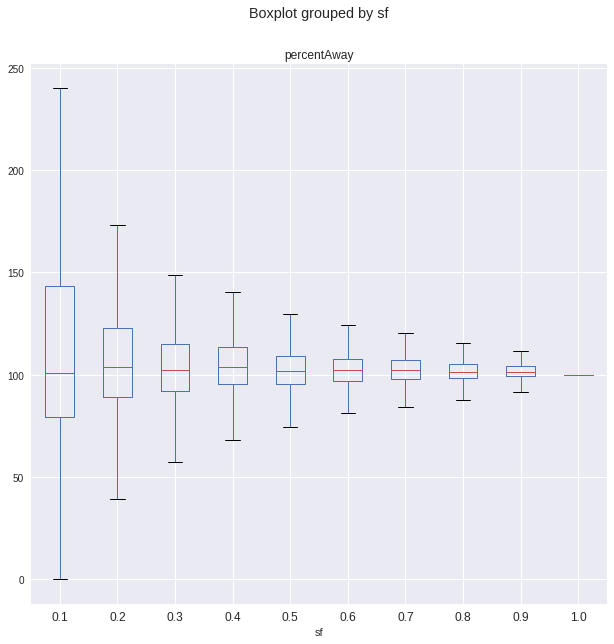

In [28]:
data.boxplot(column="percentAway", by='sf',figsize=(10,10), showfliers=False)